In [1]:
from mps_class_v9 import MPS
import numpy as np
from utils import tensor_shapes, H_ising_gen
from ncon import ncon

In [2]:
def error_psi_O_dag_O_psi(classe, site):
    classe.mpo_dagger()
    classe.mpo_Ising_O_dag_O()

    D = classe.w[0].shape[0]
    v_l = np.zeros(D)
    v_l[0] = 1
    v_r = np.zeros(D)
    v_r[-1] = 1
    aux = classe.sites[0].shape[0]
    l = np.zeros(aux)
    l[0] = 1
    r = np.zeros(aux)
    r[-1] = 1
    E_r = ncon([r.T,v_r.T,r.T], [[-1],[-2],[-3]])
    E_l = ncon([l,v_l,l], [[-1],[-2],[-3]])
    env_right = []
    env_left = []
    env_right.append(E_r)
    env_left.append(E_l)
    array = classe.sites
    for i in range(1, site):
        E_l = ncon(
            [E_l, array[i - 1], classe.w[i - 1], array[i - 1].conjugate()],
            [
                [1,3,5],
                [1,2,-1],
                [3,-2,2,4],
                [5,4,-3],
            ],
            )
        env_left.append(E_l)

    for i in range(classe.L, site, -1):
        E_r = ncon(
            [E_r, array[i - 1], classe.w[i - 1], array[i - 1].conjugate()],
            [
                [1,3,5],
                [-1,2,1],
                [-2,3,2,4],
                [-3,4,5],
            ],
            )
        env_right.append(E_r)

    ket = classe.sites
    bra = ket
    w = classe.w
    sandwich = ncon(
            [env_left[-1], ket[site - 1], w[site - 1], bra[site - 1].conjugate(), env_right[-1]],
            [
                [1,4,7],
                [1,3,2],
                [4,5,3,6],
                [7,6,8],
                [2,5,8]
            ]
        )
    return sandwich
    

In [2]:
def time_ev_sweeping(classe, trunc, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=2, precision=2):
    sweeps = ["right", "left"]
    sites = np.arange(1, classe.L + 1).tolist()
    errors = []

    # computation of mixed environments
    classe.mpo_Ising_time_ev(delta=delta, h_ev=h_ev, J_ev=J_ev)
    classe.envs(site= 1, mixed=True)
    iter = 1
    for n in range(n_sweeps):
        print(f"Sweep n: {n}\n")
        for i in range(classe.L - 1):
            classe.contraction_with_ancilla(sites[i])
            err = classe.error(site=sites[i])
            print(f"error per site {sites[i]}: {err:.5f}")
            errors.append(err)
            classe.update_envs(sweeps[0], sites[i], mixed=True)
            iter += 1

        sweeps.reverse()
        sites.reverse()

    return classe, errors[-1]

In [4]:
def TEBD_ising(classe, trunc, trotter_steps, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=4, precision=2):
    errors = []
    classe.clear_envs()
    classe._random_state(seed=3, chi=classe.chi, ancilla=True)
    classe.canonical_form(ancilla=True)
    for i in range(trotter_steps):
        print("\n======================")
        print(f"Trotter step: {i}")
        print("======================\n")
        classe, err = time_ev_sweeping(classe, trunc, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=2, precision=2)
        errors.append(err)
        print(f"Error at trotter step {i}: {err:.5f}")
    return classe, errors

In [19]:
trotter_steps = [1]
energies = []
for trott in trotter_steps:
    chain = MPS(L=80, d=2, model="Ising", chi=128, h=0, J=1, eps=0)
    chain._random_state(seed=7, chi=128)
    chain.canonical_form()
    chain.sweeping(trunc=True)
    chain._compute_norm(site=1)
    chain, errors = TEBD_ising(chain, trunc=True, trotter_steps=trott, delta=1, h_ev=0.25, J_ev=1)
    chain.clear_envs()
    chain.mpo_Ising()
    chain.envs()
    energies.append(chain.braket(site=1))

Time of env contraction: 0.1335615969983337
Sweep n: 0

Time of H_eff contraction: 0.0009290030011470662
Time of H_eff reshaping: 0.0004285949999029981
Time of eigsh during eigensolver for site 1: 0.0006535439988510916
Time of svd during update state during sweeping right for site 1: 0.00043722299960791133
Total time of state updating: 0.0006762729990441585
Time of env updating: 0.001012880999041954

Time of site 1 optimization: 0.003770171999349259

Time of H_eff contraction: 0.0005498619993886678
Time of H_eff reshaping: 0.00039411299985658843
Time of eigsh during eigensolver for site 2: 0.0007300799989025109
Time of svd during update state during sweeping right for site 2: 0.0004389530004118569
Total time of state updating: 0.0006447790001402609
Time of env updating: 0.0010133790001418674

Time of site 2 optimization: 0.003401435000341735

Time of H_eff contraction: 0.0006224730004760204
Time of H_eff reshaping: 0.00038884300010977313
Time of eigsh during eigensolver for site 3: 0.0

In [9]:
import matplotlib.pyplot as plt

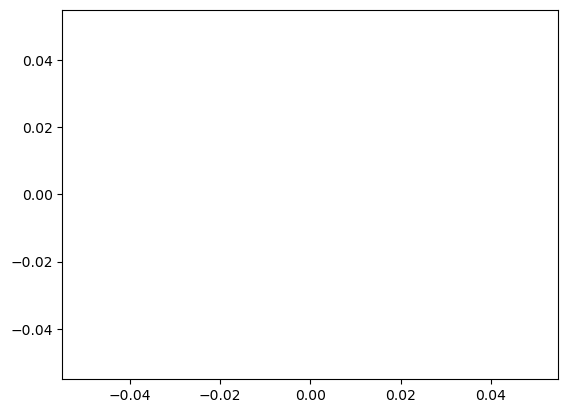

In [10]:
plt.plot(errors)

-4.758770483143632 33.163437477526344


[]

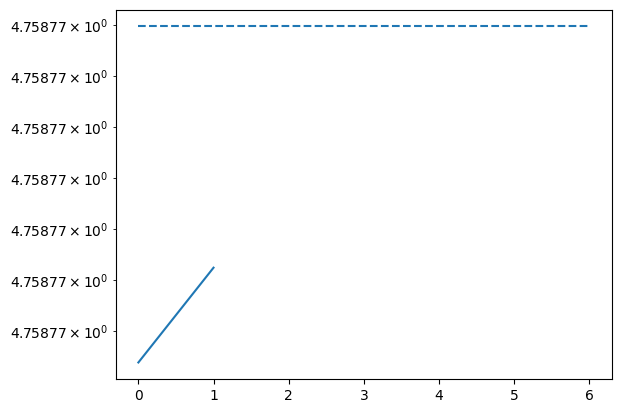

In [22]:
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
H = H_ising_gen(L=4, op_l=Z, op_t=X, J=-1, h_l=0, h_t=1)
e,v = np.linalg.eig(H)
print(e[0], e[0]**2+1-2*e[0])
plt.plot(np.abs(energies))
plt.hlines(y=np.abs(e[0]), xmin=0, xmax=6, linestyle='--')
plt.semilogy()

In [23]:
np.abs((energies[-1] - e[0])/energies[-1])

4.966212238093735e-07

In [12]:
errors

[0.0]

In [15]:
spin = MPS(L=80, d=2, model="Ising", chi=128, J=1, h=0.1, eps=0)
spin._random_state(seed=3, chi=128)
spin.canonical_form()
energies = spin.sweeping(trunc=True)
print(energies)

Time of env contraction: 0.12105521299963584
Sweep n: 0

Time of H_eff contraction: 0.0009488609994150465
Time of H_eff reshaping: 0.00040131799960363423
Time of eigsh during eigensolver for site 1: 0.0006576209998456761
Time of svd during update state during sweeping right for site 1: 0.0004297859995858744
Total time of state updating: 0.0006666720000794157
Time of env updating: 0.001010338000014599

Time of site 1 optimization: 0.0037524589997701696

Time of H_eff contraction: 0.0006008379996274016
Time of H_eff reshaping: 0.0004465450001589488
Time of eigsh during eigensolver for site 2: 0.0010385360001237132
Time of svd during update state during sweeping right for site 2: 0.0004656940000131726
Total time of state updating: 0.0006923540004208917
Time of env updating: 0.00103428799957328

Time of site 2 optimization: 0.003883675999531988

Time of H_eff contraction: 0.0005893249999644468
Time of H_eff reshaping: 0.0004501650000747759
Time of eigsh during eigensolver for site 3: 0.001

In [18]:
np.abs((energies[-1] - e[0])/energies[-1])

7.465612580780707e-16

In [16]:
tensor_shapes(spin.sites)

(1, 2, 2)
(2, 2, 4)
(4, 2, 7)
(7, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 6)
(6, 2, 7)
(7, 2, 9)
(9, 2, 10)
(10, 2, 9)
(9, 2, 8)
(8, 2, 7)
(7, 2, 7)
(7, 2, 7)
(7, 2, 7)
(7, 2, 7)
(7, 2, 7)
(7, 2, 7)
(7, 2, 7)
(7, 2, 8)
(8, 2, 7)
(7, 2, 8)
(8, 2, 8)
(8, 2, 7)
(7, 2, 8)
(8, 2, 7)
(7, 2, 8)
(8, 2, 8)
(8, 2, 7)
(7, 2, 8)
(8, 2, 7)
(7, 2, 7)
(7, 2, 8)
(8, 2, 7)
(7, 2, 7)
(7, 2, 7)
(7, 2, 8)
(8, 2, 10)
(10, 2, 8)
(8, 2, 7)
(7, 2, 7)
(7, 2, 7)
(7, 2, 8)
(8, 2, 7)
(7, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 9)
(9, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 8)
(8, 2, 10)
(10, 2, 7)
(7, 2, 9)
(9, 2, 8)
(8, 2, 9)
(9, 2, 8)
(8, 2, 7)
(7, 2, 9)
(9, 2, 9)
(9, 2, 10)
(10, 2, 7)
(7, 2, 8)
(8, 2, 9)
(9, 2, 7)
(7, 2, 10)
(10, 2, 7)
(7, 2, 9)
(9, 2, 9)
(9, 2, 8)
(8, 2, 7)
(7, 2, 4)
(4, 2, 2)
(2, 2, 1)


[(1, 2, 2),
 (2, 2, 4),
 (4, 2, 7),
 (7, 2, 8),
 (8, 2, 8),
 (8, 2, 8),
 (8, 2, 6),
 (6, 2, 7),
 (7, 2, 9),
 (9, 2, 10),
 (10, 2, 9),
 (9, 2, 8),
 (8, 2, 7),
 (7, 2, 7),
 (7, 2, 7),
 (7, 2, 7),
 (7, 2, 7),
 (7, 2, 7),
 (7, 2, 7),
 (7, 2, 7),
 (7, 2, 8),
 (8, 2, 7),
 (7, 2, 8),
 (8, 2, 8),
 (8, 2, 7),
 (7, 2, 8),
 (8, 2, 7),
 (7, 2, 8),
 (8, 2, 8),
 (8, 2, 7),
 (7, 2, 8),
 (8, 2, 7),
 (7, 2, 7),
 (7, 2, 8),
 (8, 2, 7),
 (7, 2, 7),
 (7, 2, 7),
 (7, 2, 8),
 (8, 2, 10),
 (10, 2, 8),
 (8, 2, 7),
 (7, 2, 7),
 (7, 2, 7),
 (7, 2, 8),
 (8, 2, 7),
 (7, 2, 8),
 (8, 2, 8),
 (8, 2, 8),
 (8, 2, 8),
 (8, 2, 8),
 (8, 2, 8),
 (8, 2, 9),
 (9, 2, 8),
 (8, 2, 8),
 (8, 2, 8),
 (8, 2, 8),
 (8, 2, 8),
 (8, 2, 10),
 (10, 2, 7),
 (7, 2, 9),
 (9, 2, 8),
 (8, 2, 9),
 (9, 2, 8),
 (8, 2, 7),
 (7, 2, 9),
 (9, 2, 9),
 (9, 2, 10),
 (10, 2, 7),
 (7, 2, 8),
 (8, 2, 9),
 (9, 2, 7),
 (7, 2, 10),
 (10, 2, 7),
 (7, 2, 9),
 (9, 2, 9),
 (9, 2, 8),
 (8, 2, 7),
 (7, 2, 4),
 (4, 2, 2),
 (2, 2, 1)]

In [17]:
spin.sites[0]

array([[[ 5.00004312e-02, -2.49766387e-03],
        [ 9.98746065e-01,  1.25041064e-04]]])